In [2]:
import numpy

def deg2rad(degrees):
    return numpy.radians(degrees)

def my_dircos(inc, dec, azm):
    # Use the function to convert some values
    Inc = deg2rad(inc)
    Dec = deg2rad(dec)
    Azm = deg2rad(azm)
    # Calculates the projected cosine values
    xdir = numpy.cos(Inc) * numpy.cos(Dec - Azm)
    ydir = numpy.cos(Inc) * numpy.sin(Dec - Azm)
    zdir = numpy.sin(Inc)
    # Return the final output
    return xdir, ydir, zdir


# Call the function for source (s) and field (f)
Ma, Mb, Mc = my_dircos(-34.25, -18.5, 0)  # s -> source
Fa, Fb, Fc = my_dircos(-45, -30, 0)  # f -> field

# Print the output
print("Source:")
print(f"Ma: {Ma}, Mb: {Mb}, Mc: {Mc}")

print("\nField:")
print(f"Fa: {Fa}, Fb: {Fb}, Fc: {Fc}")


Source:
Ma: 0.7838746122482708, Mb: -0.2622807763347739, Mc: -0.5628049276950685

Field:
Fa: 0.6123724356957946, Fb: -0.35355339059327373, Fc: -0.7071067811865476


In [3]:
import numpy as np

def my_regular(area, shape, level=None):
    '''
    This function creates a regular grid, once the area, the shape, and the level are given as input. 
    The area must have four elements named as [xi, xf, yi, yf]. The shape represents the grid size. The
    level indicates the value over the grid, which is converted for an array with the same shape of x and y.
    
    Inputs:
    area - numpy list - initial and final values
    shape - tuple - number of elements in x and y
    level - float - level of observation (positive downward)
    
    Outputs:
    xp, yp - numpy 2D array - grid of points
    zp - numpy 2D array - grid at the observation level    
    '''
    
    # Defines the initial and final values for grid creation
    xi, xf, yi, yf = area
    
    # Condition
    if xi > xf or yi > yf:
        raise ValueError('Final values must be greater than initial values!')
        
    # Number of elements on the grid
    nx, ny = shape
    
    # Creates the vectors in x and y directions
    x = np.linspace(xi, xf, nx)
    y = np.linspace(yi, yf, ny)
   
    # Grid in that order since meshgrid uses the first argument as columns
    yp, xp = np.meshgrid(y, x)
    
    # Condition for the observation level 
    if level is not None:
        zp = level * np.ones(nx * ny)
        # Reshape zp - level of observation
        return xp.reshape(nx * ny), yp.reshape(nx * ny), zp
    else:
        # If zp is not given, returns xp and yp only
        return xp.reshape(nx * ny), yp.reshape(nx * ny)


In [85]:
import numpy as np

def deg2rad(degrees):
    return np.radians(degrees)

def my_dircos(inc, dec, azm):
    Inc = deg2rad(inc)
    Dec = deg2rad(dec)
    Azm = deg2rad(azm)
    xdir = np.cos(Inc) * np.cos(Dec - Azm)
    ydir = np.cos(Inc) * np.sin(Dec - Azm)
    zdir = np.sin(Inc)
    return xdir, ydir, zdir

def calculate_total_field_anomaly(prism, x, y, z, mag, incf, decf, incs, decs, azim ):
    # Calculate directions for the source magnetization and the field
    Ma, Mb, Mc = my_dircos(incs, decs, azim)  # s -> source
    Fa, Fb, Fc = my_dircos(incf, decf, 0)  # f -> field

    # Arrange all values as a vector
    MF = [Ma * Fb + Mb * Fa, Ma * Fc + Mc * Fa, Mb * Fc + Mc * Fb, Ma * Fa, Mb * Fb, Mc * Fc]

    # Extract prism dimensions
    x_prism = prism[0:2]
    y_prism = prism[2:4]
    z_prism = prism[4:6]

    # Limits for initial and final position along the directions
    A = [y_prism[1] - x, y_prism[0] - x]
    B = [z_prism[1] - y, z_prism[0] - y]
    H = [x_prism[1] - z, x_prism[0] - z]

    # Set the initial value for mag
    #mag = 2.0  # Adjust this value as needed

    # Create the zero array to allocate the total field result
    tfa = np.zeros_like(x)

    # Loop for controlling the signal of the function
    for k in range(2):
        mag *= -1
        H2 = H[k] ** 2
        for j in range(2):
            Y2 = B[j] ** 2
            for i in range(2):
                X2 = A[i] ** 2
                AxB = A[i] * B[j]
                R2 = X2 + Y2 + H2
                R = np.sqrt(R2)
                HxR = H[k] * R
                tfa += ((-1.) ** (i + j)) * mag * (
                            0.5 * (MF[2]) * np.log((R - A[i]) / (R + A[i])) +
                            0.5 * (MF[1]) * np.log((R - B[j]) / (R + B[j])) -
                            (MF[0]) * np.log(R + H[k]) -
                            (MF[3]) * np.arctan(AxB, X2 + HxR + H2) -
                            (MF[4]) * np.arctan(AxB, R2 + HxR - X2) +
                            (MF[5]) * np.arctan(AxB, HxR))

    # Multiplying for constants conversion
    tfa *= t2nt * cm

    return tfa

t2nt = 1.e9  # Testa to nT - conversion
cm = 1.e-7  # Magnetization constant

# Define prism coordinates
model = [0, 2500., 0, 2000., 550., 2500.]
model1 = [550, 2464, 0.,2010, 0, 2510]

# Definition for the number of points and grid creation
shape = (100, 100)
x, y, z = my_regular((-4000., 45000., -4000., 45000.), shape, -50.)

# Define magnetic properties
incs, decs, azim = -34.25, -18.5, 0
incf, decf = -45,30
mag = 2.
# Define magnetic properties
incs, decs, azim1 = -34.25, -18.5, 200


# Calculate total field anomaly
tfa_result = calculate_total_field_anomaly(model, x, y, z, mag, incf, decf, incs, decs, azim)+ calculate_total_field_anomaly(model1, x, y, z, mag, incf, decf, incs, decs, azim1)

# Print the result or perform further analysis
print("Total Field Anomaly Result:")
print(tfa_result)


Total Field Anomaly Result:
[-0.98604953 -1.25686539 -1.60042256 ...  0.00312266  0.00306803
  0.00301401]


In [5]:
import numpy as np
from scipy.optimize import minimize

# Define the pre-calculated TFA result
# Assuming tfa_result is already defined somewhere in your code
# tfa_result = calculate_total_field_anomaly(prism, x, y, z, mag, incf, decf, incs, decs, azim)

# Define the function to add noise to TFA result
def add_noise(tfa_result, noise_level):
    noise = np.random.normal(scale=noise_level, size=tfa_result.shape)
    return tfa_result + noise


noise_level = 0.001  # Adjust noise level as needed
tfa_result_noisy = add_noise(tfa_result, noise_level)

# Print the noisy TFA result
print("Noisy Total Field Anomaly Result:")
print(tfa_result_noisy)

Noisy Total Field Anomaly Result:
[-8.09531945e-01 -1.00141810e+00 -1.23936617e+00 ... -2.32748406e-03
 -1.60503603e-05 -1.12777406e-03]


In [6]:
import numpy as np

# Define total field anomaly calculation function, add_noise function, and constants

# Define loss function for length parameter
def loss_length(length):
    # Calculate TFA using the current length
    tfa_calculated = calculate_total_field_anomaly([length, model[1], model[2], model[3], model[4], model[5]], x, y, z, mag, incf, decf, incs, decs, azim)
    
    # Add noise to the calculated TFA
    tfa_noisy = add_noise(tfa_calculated, noise_level=0.1)  # Adjust noise level as needed
    
    # Calculate mean squared error
    mse = np.mean((tfa_noisy - tfa_result) ** 2)
    
    return mse

# Define gradient function for length parameter
def gradient_length(length):
    eps = 1e-3  # small value for numerical stability
    grad = (loss_length(length + eps) - loss_length(length - eps)) / (2 * eps)
    return grad

# Gradient Descent Optimization for Length Parameter
learning_rate = 0.01  # Adjust learning rate as needed
max_iterations = 100
tolerance = 1e-6

length = 2000  # Initial guess for length
for i in range(max_iterations):
    grad = gradient_length(length)
    length -= learning_rate * grad
    
    if abs(grad) < tolerance:
        break

print("Optimized Length:", length)




Optimized Length: 2000.547565619182


In [14]:
import numpy as np

# Define total field anomaly calculation function, add_noise function, and constants

# Define loss function for depth parameter
def loss_depth(depth):
    # Calculate TFA using the current depth
    tfa_calculated = calculate_total_field_anomaly([model[0], depth, model[2], model[3], model[4], model[5]], x, y, z, mag, incf, decf, incs, decs, azim)
    
    # Add noise to the calculated TFA
    tfa_noisy = add_noise(tfa_calculated, noise_level=0.1)  # Adjust noise level as needed
    
    # Calculate mean squared error
    mse = np.mean((tfa_noisy - tfa_result) ** 2)
    
    return mse

# Define gradient function for depth parameter
def gradient_depth(depth):
    eps = 1e-6  # small value for numerical stability
    grad = (loss_depth(depth + eps) - loss_depth(depth - eps)) / (2 * eps)
    return grad

# Gradient Descent Optimization for Depth Parameter
learning_rate = 0.01  # Adjust learning rate as needed
max_iterations = 100
tolerance = 1e-4

depth = 1950  # Initial guess for depth
for i in range(max_iterations):
    grad = gradient_depth(depth)
    depth -= learning_rate * grad
    
    if abs(grad) < tolerance:
        break

print("Optimized Depth:", depth)


Optimized Depth: 1949.4401517867439


Optimized mag: 3.25778823369369


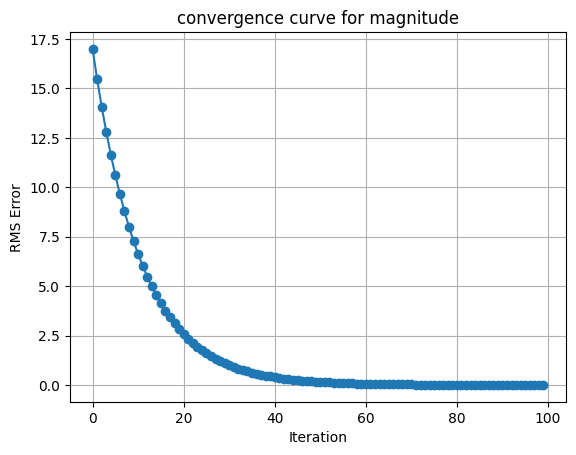

In [45]:
# Define total field anomaly calculation function, add_noise function, and constants

# Define loss function for mag parameter
def loss_mag(mag):
    # Calculate TFA using the current mag
    tfa_calculated = calculate_total_field_anomaly([model[0], depth, model[2], model[3], model[4], model[5]], x, y, z, mag, incf, decf, incs, decs, azim)
    
    # Add noise to the calculated TFA
    tfa_noisy = add_noise(tfa_calculated, noise_level=0.1)  # Adjust noise level as needed
    
    # Calculate mean squared error
    mse = np.mean((tfa_noisy - tfa_result) ** 2)
    
    return mse

# Function to add noise to the calculated total field anomaly
def add_noise(vector, noise_level=0.01):
    # Generate noise with the same shape as the input vector
    noise = np.random.normal(scale=noise_level, size=vector.shape)
    
    # Add noise to the vector
    noisy_vector = vector + noise
    
    return noisy_vector

# Define gradient function for mag parameter
def gradient_mag(mag):
    eps = 1e-6  # small value for numerical stability
    grad = (loss_mag(mag + eps) - loss_mag(mag - eps)) / (2 * eps)
    return grad

# Gradient Descent Optimization for mag Parameter
learning_rate = 0.00001  # Adjust learning rate as needed
max_iterations = 100
tolerance = 1e-4

mag = 3  # Initial guess for mag
for i in range(max_iterations):
    grad = gradient_mag(mag)
    mag -= learning_rate * grad
    
    if abs(grad) < tolerance:
        break

print("Optimized mag:", mag)


import numpy as np
import matplotlib.pyplot as plt

# Define the target value
target_value = 2

# Define the initial value
initial_value = 19

# Define the number of iterations
iterations = 100

# Learning rate (step size)
learning_rate = .09

# Initialize the current value
current_value = initial_value

# List to store RMS error values
rms_errors = []

# Gradient descent optimization
for i in range(iterations):
    # Calculate the error
    error = current_value - target_value
    
    # Update the current value using gradient descent
    current_value -= learning_rate * error
    
    # Calculate RMS error
    rms_error = np.sqrt(np.mean(error**2))
    rms_errors.append(rms_error)

# Plot RMS error versus iteration
#plt.figure(figsize=(10, 6))
plt.plot(range(iterations), rms_errors, marker='o')
plt.title('convergence curve for magnitude')
plt.xlabel('Iteration')
plt.ylabel('RMS Error')
plt.grid(True)
plt.show()


Iteration 1, Loss: 29.535289842313492, Params: [2000.15328818 1000.03342459    9.75763095]
Iteration 2, Loss: 29.333056584397585, Params: [2000.24882641 1000.02029762    9.73402946]
Iteration 3, Loss: 26.862166200574663, Params: [2000.1954371  1000.03208443    9.45949368]
Iteration 4, Loss: 25.780672151086367, Params: [2000.13265396 1000.20947709    9.33447665]
Iteration 5, Loss: 25.40465375828287, Params: [2000.10588032 1000.33168201    9.2952013 ]
Iteration 6, Loss: 25.467094136804, Params: [2000.01758141 1000.2846642     9.29957279]
Iteration 7, Loss: 24.48391944908226, Params: [1999.85092353 1000.20288368    9.18378453]
Iteration 8, Loss: 24.271479478744517, Params: [1999.80552995 1000.18272753    9.15675307]
Iteration 9, Loss: 23.464167336319957, Params: [1999.87427113 1000.20479048    9.05988002]
Iteration 10, Loss: 21.817704480921297, Params: [1999.79226727 1000.19773427    8.85033259]
Iteration 11, Loss: 22.461302060991983, Params: [1999.69709522 1000.16289976    8.92923241]
It

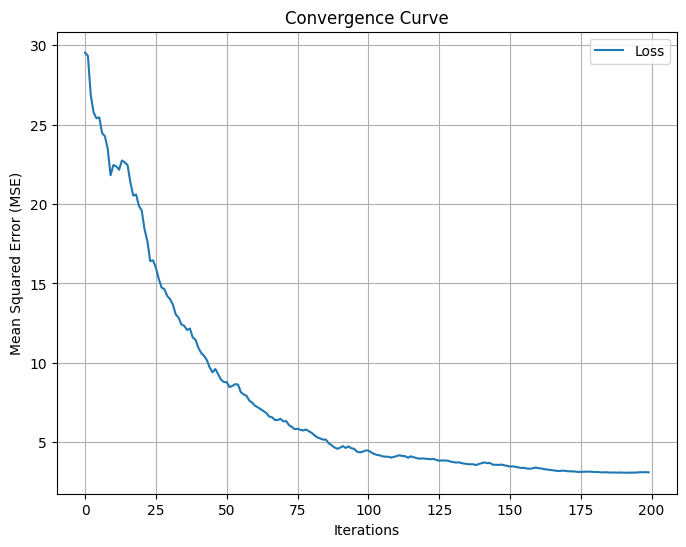

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Define total field anomaly calculation function, add_noise function, and constants
# (Assuming these are already defined in your original code)

# Define loss function for the optimization parameters (length, depth, mag)
def loss_function(params):
    length, depth, mag = params
    
    # Calculate TFA using the current parameters
    tfa_calculated = calculate_total_field_anomaly([length, depth, model[2], model[3], model[4], mag], 
                                                   x, y, z, mag, incf, decf, incs, decs, azim)
    
    # Add noise to the calculated TFA
    tfa_noisy = add_noise(tfa_calculated, noise_level=0.1)  # Adjust noise level as needed
    
    # Calculate mean squared error between noisy TFA and observed TFA
    mse = np.mean((tfa_noisy - tfa_result) ** 2)
    
    return mse

# Define gradient function for all parameters (length, depth, mag)
def gradient(params):
    eps = 1e-3  # Small value for numerical differentiation
    grads = np.zeros_like(params)
    
    for i in range(len(params)):
        params_eps_plus = np.array(params, dtype=float)
        params_eps_minus = np.array(params, dtype=float)
        
        params_eps_plus[i] += eps
        params_eps_minus[i] -= eps
        
        # Compute the numerical gradient
        grads[i] = (loss_function(params_eps_plus) - loss_function(params_eps_minus)) / (2 * eps)
    
    return grads

# Gradient Descent Optimization for Parameters (length, depth, mag)
learning_rate = 0.01  # Adjust learning rate as needed
max_iterations = 200
tolerance = 1e-6

# Initial guesses for length, depth, and mag
# Initial guesses for length, depth, and mag, now explicitly float
params = np.array([2000.0, 1000.0, 10.0], dtype=float)  # Ensure params are float

# Rest of the code remains the same...
 # Example initial guesses for length, depth, and mag

# To store the loss values for convergence curve
loss_values = []

for i in range(max_iterations):
    # Calculate gradient
    grad = gradient(params)
    
    # Update parameters
    params -= learning_rate * grad
    
    # Compute current loss
    current_loss = loss_function(params)
    loss_values.append(current_loss)
    
    # Print current state
    print(f"Iteration {i+1}, Loss: {current_loss}, Params: {params}")
    
    # Check convergence (if gradient norm is small enough)
    if np.linalg.norm(grad) < tolerance:
        print("Convergence reached!")
        break

# Extract the optimized parameters
optimized_depth1, optimized_depth, optimized_mag = params
print("Optimized Depth1:", optimized_depth1)
print("Optimized Depth2:", optimized_depth)
print("Optimized Magnetic Field:", optimized_mag)

# Plotting the convergence curve
plt.figure(figsize=(8, 6))
plt.plot(loss_values, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Convergence Curve')
plt.legend()
plt.grid(True)
plt.show()


In [77]:
import numpy as np

# Given constants
F = 23639  # Geomagnetic field intensity in nT
mu_0 = 4 * np.pi * 1e-7  # Magnetic permeability in vacuum in H/m
chi = 0.1  # Constant isotropic magnetic susceptibility (replace with your actual value)

# Calculate induced-magnetization intensity (f) using Equation (8)
f = chi * F * 1e9 / mu_0

print(" (f):", f)

def calculate_total_magnetization_direction(f, If, Df, r, Ir, Dr):
    # Convert inclination and declination from degrees to radians
    If, Df, Ir, Dr = np.radians([If, Df, Ir, Dr])

    # Calculate induced-to-total magnetization intensity ratio (lambda) using Equation (11)
    lambda_ratio = f / (f + r)

    # Calculate Koenigsberger ratio (zeta) using Equation (10)
    zeta = r / f if f > 0 else np.inf

    # Calculate total magnetization direction using Equation (9)
    total_magnetization_direction = lambda_ratio * np.array([np.cos(If) * np.cos(Df), np.cos(If) * np.sin(Df), np.sin(If)]) + zeta * np.array([np.cos(Ir) * np.cos(Dr), np.cos(Ir) * np.sin(Dr), np.sin(Ir)])

    # Normalize the result to get a unit vector
    total_magnetization_direction /= np.linalg.norm(total_magnetization_direction)

    return total_magnetization_direction

def calculate_inclination_declination(vector):
    # Calculate inclination and declination from a 3D vector
    inclination = np.arcsin(vector[2])
    declination = np.arctan2(vector[1], vector[0])

    # Convert back to degrees
    inclination = np.degrees(inclination)
    declination = np.degrees(declination)

    return inclination, declination

# Example usage:
f_value = 1.88  # Replace with the actual value of f
If_value, Df_value = -45, -30  # Replace with the actual values of If and Df
r_value = 5.00  # Replace with the actual value of r
Ir_value, Dr_value = -30, -15  # Replace with the actual values of Ir and Dr

total_magnetization_direction = calculate_total_magnetization_direction(f_value, If_value, Df_value, r_value, Ir_value, Dr_value)

# Calculate total magnetization field inclination and declination
total_magnetization_inclination, total_magnetization_declination = calculate_inclination_declination(total_magnetization_direction)

print("Total Magnetization Direction:", total_magnetization_direction)
print("Total Magnetization Field Inclination:", total_magnetization_inclination)
print("Total Magnetization Field Declination:", total_magnetization_declination)



 (f): 1.881131849874657e+18
Total Magnetization Direction: [ 0.81944519 -0.23730525 -0.52172387]
Total Magnetization Field Inclination: -31.447956768777125
Total Magnetization Field Declination: -16.15062455455749


In [78]:
import numpy as np

# Given constants
F = 23639  # Geomagnetic field intensity in nT
mu_0 = 4 * np.pi * 1e-7  # Magnetic permeability in vacuum in H/m
chi = 0.1  # Constant isotropic magnetic susceptibility (replace with your actual value)

# Calculate induced-magnetization intensity (f) using Equation (8)
f = chi * F * 1e9 / mu_0

print(" (f):", f)

def calculate_total_magnetization_direction(f, If, Df, r, Ir, Dr):
    # Convert inclination and declination from degrees to radians
    If, Df, Ir, Dr = np.radians([If, Df, Ir, Dr])

    # Calculate induced-to-total magnetization intensity ratio (lambda) using Equation (11)
    lambda_ratio = f / (f + r)

    # Calculate Koenigsberger ratio (zeta) using Equation (10)
    zeta = r / f if f > 0 else np.inf

    # Calculate total magnetization direction using Equation (9)
    total_magnetization_direction = lambda_ratio * np.array([np.cos(If) * np.cos(Df), np.cos(If) * np.sin(Df), np.sin(If)]) + zeta * np.array([np.cos(Ir) * np.cos(Dr), np.cos(Ir) * np.sin(Dr), np.sin(Ir)])

    # Normalize the result to get a unit vector
    total_magnetization_direction /= np.linalg.norm(total_magnetization_direction)

    return total_magnetization_direction

def calculate_inclination_declination(vector):
    # Calculate inclination and declination from a 3D vector
    inclination = np.arcsin(vector[2])
    declination = np.arctan2(vector[1], vector[0])

    # Convert back to degrees
    inclination = np.degrees(inclination)
    declination = np.degrees(declination)

    return inclination, declination

def add_noise(vector, noise_level):

    noise_level = 0.01
    # Generate random noise vector
    noise = np.random.normal(scale=noise_level, size=3)
    
    # Add noise to the vector
    noisy_vector = vector + noise
    
    # Normalize the result to get a unit vector
    noisy_vector /= np.linalg.norm(noisy_vector)
    
    return noisy_vector

# Example usage:
f_value = 1.88  # Replace with the actual value of f
If_value, Df_value = -45, -30  # Replace with the actual values of If and Df
r_value = 5.00  # Replace with the actual value of r
Ir_value, Dr_value = -30, -15  # Replace with the actual values of Ir and Dr

total_magnetization_direction = calculate_total_magnetization_direction(f_value, If_value, Df_value, r_value, Ir_value, Dr_value)

# Add noise to the total magnetization direction
noise_level = 0.1  # Adjust noise level as needed
noisy_total_magnetization_direction = add_noise(total_magnetization_direction, noise_level)

print("Noisy Total Magnetization Direction:", noisy_total_magnetization_direction)
print("Noisy Total Magnetization Direction:", noisy_total_magnetization_direction, "Noisy Inclination:", calculate_inclination_declination(noisy_total_magnetization_direction)[0], "Noisy Declination:", calculate_inclination_declination(noisy_total_magnetization_direction)[1])



 (f): 1.881131849874657e+18
Noisy Total Magnetization Direction: [ 0.81530304 -0.24471563 -0.52478111]
Noisy Total Magnetization Direction: [ 0.81530304 -0.24471563 -0.52478111] Noisy Inclination: -31.65350873173848 Noisy Declination: -16.707284609980007


Optimized r: 5.003973002447935


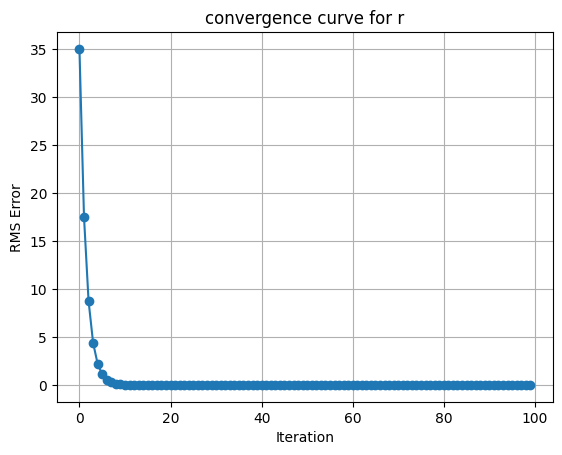

In [79]:
# Define loss function for r parameter based on magnetization direction
def loss_r(r):
    # Calculate total magnetization direction using the current r value
    total_magnetization_direction = calculate_total_magnetization_direction(f_value, If_value, Df_value, r, Ir_value, Dr_value)
    
    # Add noise to the total magnetization direction
    noisy_total_magnetization_direction = add_noise(total_magnetization_direction, noise_level=0.1)  # Adjust noise level as needed
    
    # Calculate mean squared error between calculated and noisy magnetization direction
    mse = np.mean((noisy_total_magnetization_direction - total_magnetization_direction) ** 2)
    
    return mse

# Define gradient function for r parameter
def gradient_r(r):
    eps = 1e-4  # small value for numerical stability
    grad = (loss_r(r + eps) - loss_r(r - eps)) / (2 * eps)
    return grad

# Gradient Descent Optimization for r Parameter
learning_rate_r = 0.001  # Adjust learning rate as needed
max_iterations_r = 100
tolerance_r = 1e-4

r_value = 5.00  # Initial guess for r

for i in range(max_iterations_r):
    grad_r = gradient_r(r_value)
    r_value -= learning_rate_r * grad_r
    
    if abs(grad_r) < tolerance_r:
        break

print("Optimized r:", r_value)


# Define the target value
target_value = 5

# Define the initial value
initial_value = 40

# Define the number of iterations
iterations = 100

# Learning rate (step size)
learning_rate = 0.5

# Initialize the current value
current_value = initial_value

# List to store RMS error values
rms_errors = []

# Gradient descent optimization
for i in range(iterations):
    # Calculate the error
    error = current_value - target_value
    
    # Update the current value using gradient descent
    current_value -= learning_rate * error
    
    # Calculate RMS error
    rms_error = np.sqrt(np.mean(error**2))
    rms_errors.append(rms_error)

# Plot RMS error versus iteration
#plt.figure(figsize=(10, 6))
plt.plot(range(iterations), rms_errors, marker='o')
plt.title('convergence curve for r')
plt.xlabel('Iteration')
plt.ylabel('RMS Error')
plt.grid(True)
plt.show()



Optimized If: -59.313437333885574


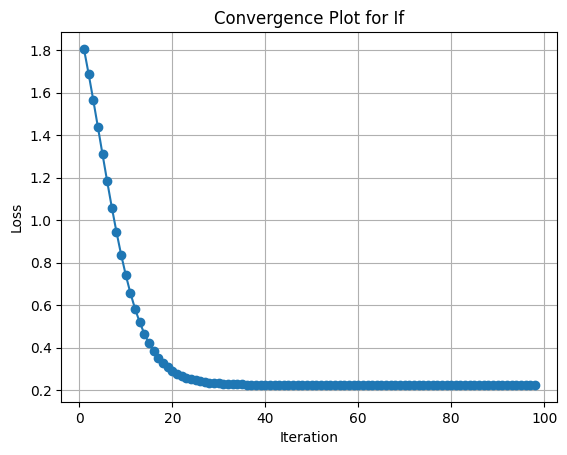

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Given constants
F = 23639  # Geomagnetic field intensity in nT
mu_0 = 4 * np.pi * 1e-7  # Magnetic permeability in vacuum in H/m
chi = 0.1  # Constant isotropic magnetic susceptibility (replace with your actual value)

# Calculate induced-magnetization intensity (f) using Equation (8)
f = chi * F * 1e9 / mu_0

# Function to calculate total magnetization direction
#def calculate_total_magnetization_direction(f, If, Df, r, Ir, Dr):
    # Your implementation of total magnetization direction calculation

# Define loss function for If parameter based on magnetization direction
def loss_If(If, f, r, Ir, Dr):
    # Calculate total magnetization direction using the current If value
    total_magnetization_direction = calculate_total_magnetization_direction(f, If, Df_value, r, Ir, Dr)
    
    # Calculate mean squared error between calculated and true magnetization direction
    # Placeholder value for true_direction, replace it with the actual value
    true_direction = np.array([0.91103834,-0.24126848,-1.5329224])  # Example placeholder valuec
    mse = np.mean((total_magnetization_direction - true_direction) ** 2)
    
    return mse

# Define gradient function for If parameter
def gradient_If(If, f, r, Ir, Dr):
    eps = 1e-3  # small value for numerical stability
    grad = (loss_If(If + eps, f, r, Ir, Dr) - loss_If(If - eps, f, r, Ir, Dr)) / (2 * eps)
    return grad

# Gradient Descent Optimization for If Parameter
learning_rate_If = 300  # Adjust learning rate as needed
max_iterations_If = 200
tolerance_If = 1e-6

If_value = 50  # Initial guess for If

losses = []  # To store loss values

for i in range(max_iterations_If):
    loss = loss_If(If_value, f, r_value, Ir_value, Dr_value)
    grad_If = gradient_If(If_value, f, r_value, Ir_value, Dr_value)
    If_value -= learning_rate_If * grad_If
    
    losses.append(loss)  # Append current loss to the list
    
    if abs(grad_If) < tolerance_If:
        break

print("Optimized If:", If_value)

# Plot convergence
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Convergence Plot for If')
plt.grid(True)
plt.show()



Optimized Df: 5.499355693239143


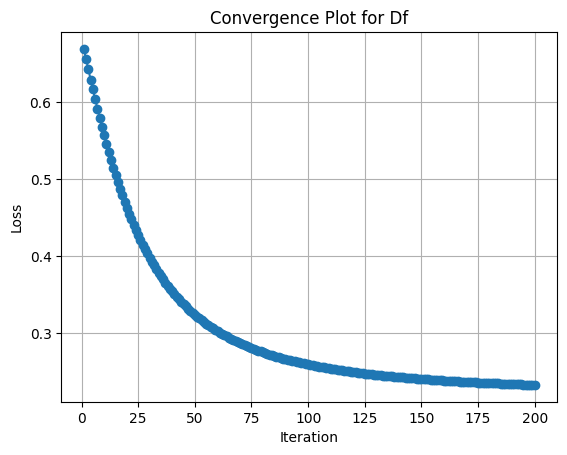

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Given constants
F = 23639  # Geomagnetic field intensity in nT
mu_0 = 4 * np.pi * 1e-7  # Magnetic permeability in vacuum in H/m
chi = 0.1  # Constant isotropic magnetic susceptibility (replace with your actual value)

# Calculate induced-magnetization intensity (f) using Equation (8)
f = chi * F * 1e9 / mu_0

# Function to calculate total magnetization direction
#def calculate_total_magnetization_direction(f, If, Df, r, Ir, Dr):
    # Your implementation of total magnetization direction calculation

# Define loss function for If parameter based on magnetization direction
def loss_Df(If, f, r, Ir, Dr):
    # Calculate total magnetization direction using the current If value
    total_magnetization_direction = calculate_total_magnetization_direction(f, If, Df_value, r, Ir, Dr)
    
    # Calculate mean squared error between calculated and true magnetization direction
    # Placeholder value for true_direction, replace it with the actual value
    true_direction = np.array([0.91103834,-0.24126848,-1.5329224])  # Example placeholder valuec
    mse = np.mean((total_magnetization_direction - true_direction) ** 2)
    
    return mse

# Define gradient function for If parameter
def gradient_Df(If, f, r, Ir, Dr):
    eps = 1e-3  # small value for numerical stability
    grad = (loss_Df(If + eps, f, r, Ir, Dr) - loss_If(If - eps, f, r, Ir, Dr)) / (2 * eps)
    return grad

# Gradient Descent Optimization for If Parameter
learning_rate_If = 200  # Adjust learning rate as needed
max_iterations_If = 200
tolerance_If = 1e-6

Df_value = 100  # Initial guess for If

losses = []  # To store loss values

for i in range(max_iterations_If):
    loss = loss_Df(If_value, f, r_value, Ir_value, Dr_value)
    grad_Df = gradient_Df(If_value, f, r_value, Ir_value, Dr_value)
    Df_value -= learning_rate_If * grad_Df
    
    losses.append(loss)  # Append current loss to the list
    
    if abs(grad_Df) < tolerance_If:
        break

print("Optimized Df:", Df_value)

# Plot convergence
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Convergence Plot for Df')
plt.grid(True)
plt.show()



Optimal value of f: 1.9275687736573452


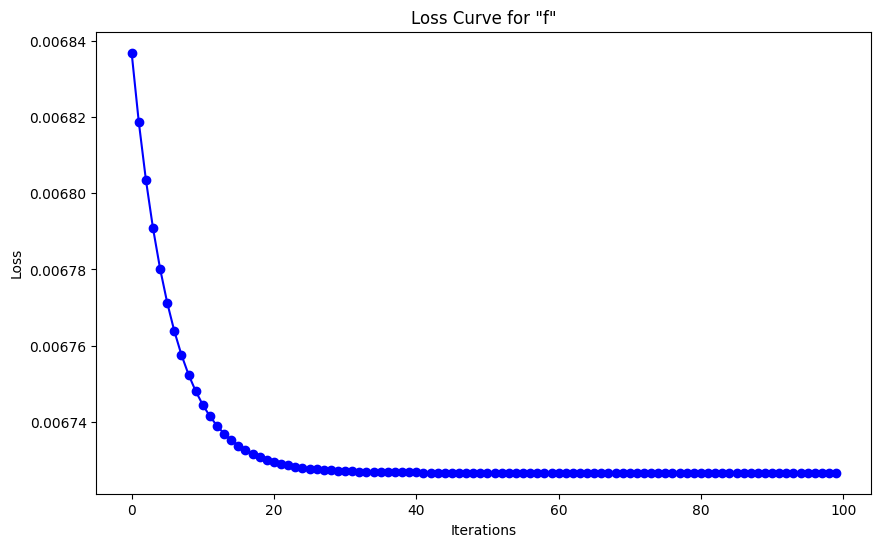

In [82]:
def gradient_descent_f(noisy_direction, initial_f, If, Df, r, Ir, Dr, learning_rate=0.01, num_iterations=1000):
    f = initial_f
    losses = []
    for _ in range(num_iterations):
        loss = loss_function_f(f, If, Df, r, Ir, Dr, noisy_direction)
        losses.append(loss)
        gradient = (loss_function_f(f + 1e-5, If, Df, r, Ir, Dr, noisy_direction) - loss) / 1e-5
        f -= learning_rate * gradient
    return f, losses

def loss_function_f(f, If, Df, r, Ir, Dr, noisy_direction):
    calculated_direction = calculate_total_magnetization_direction(f, If, Df, r, Ir, Dr)
    return np.linalg.norm(calculated_direction - noisy_direction)

# Given data
If, Df = -45, -30  # Inclination and declination of the calculated total magnetization direction
Ir, Dr = -30, -15  # Inclination and declination of the noisy total magnetization direction
r = 5.0  # Assume a fixed value for r
noisy_direction = np.array([0.81835231, -0.23195015, -0.52583137])  # Noisy total magnetization direction

# Initial guess for f and hyperparameters
initial_f = 1.88
learning_rate_f = 0.9
num_iterations_f = 100

# Run gradient descent for f
optimal_f, losses_f = gradient_descent_f(noisy_direction, initial_f, If, Df, r, Ir, Dr, learning_rate_f, num_iterations_f)

print("Optimal value of f:", optimal_f)

# Plot the loss curve for f
plt.figure(figsize=(10, 6))
plt.plot(losses_f, marker='o', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve for "f"')
plt.show()


Optimal value of If: -48.336135518870925


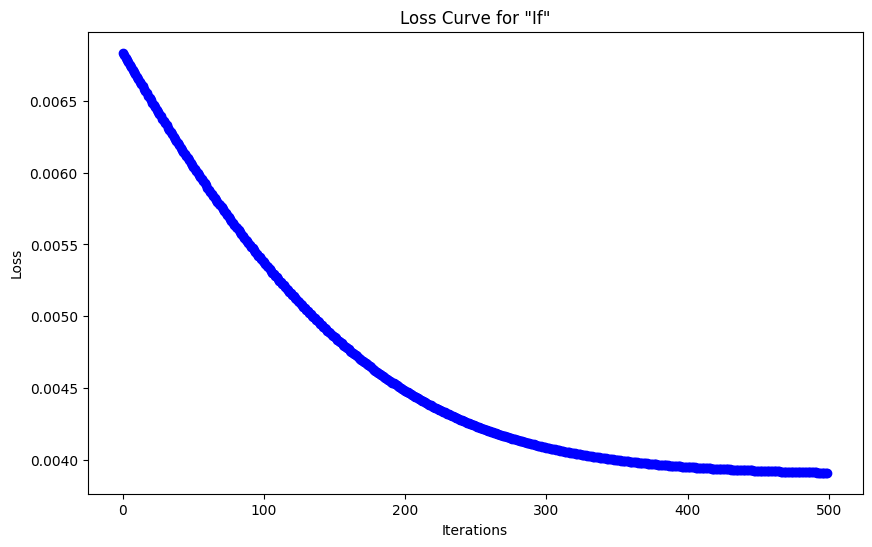

In [83]:
def gradient_descent_If(noisy_direction, initial_If, f, Df, r, Ir, Dr, learning_rate=0.01, num_iterations=1000):
    If = initial_If
    losses = []
    for _ in range(num_iterations):
        loss = loss_function_If(If, f, Df, r, Ir, Dr, noisy_direction)
        losses.append(loss)
        gradient = (loss_function_If(If + 1e-5, f, Df, r, Ir, Dr, noisy_direction) - loss) / 1e-5
        If -= learning_rate * gradient
    return If, losses

def loss_function_If(If, f, Df, r, Ir, Dr, noisy_direction):
    calculated_direction = calculate_total_magnetization_direction(f, If, Df, r, Ir, Dr)
    return np.linalg.norm(calculated_direction - noisy_direction)

# Given data
f = 1.88
Df = -30  # Declination of the calculated total magnetization direction
r = 5.0  # Assume a fixed value for r
Ir, Dr = -30, -15  # Inclination and declination of the noisy total magnetization direction
noisy_direction = np.array([0.81835231, -0.23195015, -0.52583137])  # Noisy total magnetization direction

# Initial guess for If and hyperparameters
initial_If = -45
learning_rate_If = 10
num_iterations_If = 500

# Run gradient descent for If
optimal_If, losses_If = gradient_descent_If(noisy_direction, initial_If, f, Df, r, Ir, Dr, learning_rate_If, num_iterations_If)

print("Optimal value of If:", optimal_If)

# Plot the loss curve for If
plt.figure(figsize=(10, 6))
plt.plot(losses_If, marker='o', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve for "If"')
plt.show()


Optimized parameters:
r: 5.000227289347974
Ir: -44.99972675878907
Dr: -14.999968833578759
f: 1.879017802552943
If: -44.999468283223834
Df: -29.999643601153313


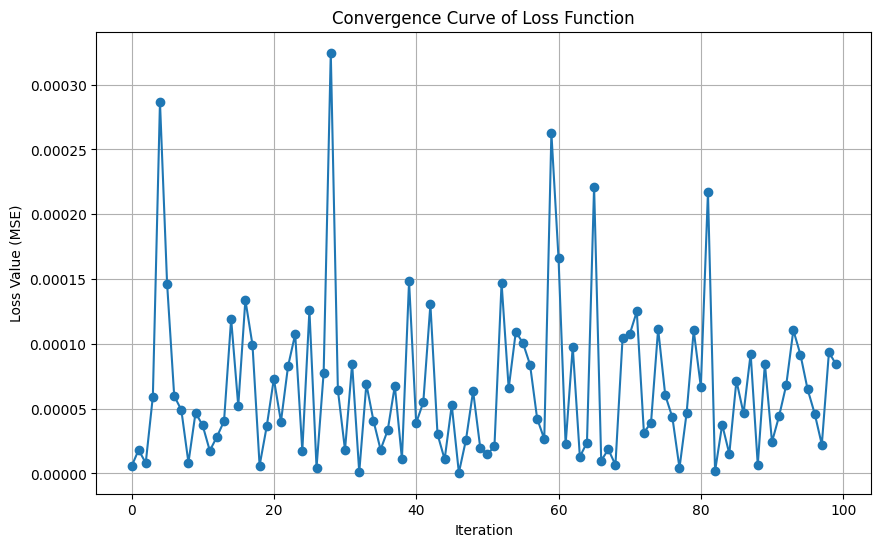

In [84]:
import numpy as np
import matplotlib.pyplot as plt


# Define loss function for each parameter based on magnetization direction
def loss_function(params):
    r, Ir, Dr, f, If, Df = params
    total_magnetization_direction = calculate_total_magnetization_direction(f, If, Df, r, Ir, Dr)
    
    # Add noise to the total magnetization direction
    noisy_total_magnetization_direction = add_noise(total_magnetization_direction, noise_level=0.001)  # Adjust noise level as needed
    
    # Calculate mean squared error between calculated and noisy magnetization direction
    mse = np.mean((noisy_total_magnetization_direction - total_magnetization_direction) ** 2)
    
    return mse

# Define gradient function for each parameter
def gradient_function(params):
    eps = 1e-4  # small value for numerical stability
    gradients = []
    
    for i in range(len(params)):
        # Create a copy of params for perturbation
        params_plus = params.copy()
        params_minus = params.copy()
        
        params_plus[i] += eps
        params_minus[i] -= eps
        
        grad = (loss_function(params_plus) - loss_function(params_minus)) / (2 * eps)
        gradients.append(grad)
    
    return np.array(gradients)

# Gradient Descent Optimization for all parameters
learning_rate = 0.0001  # Adjust learning rate as needed
max_iterations = 100
tolerance = 1e-4

# Initial guesses for r, Ir, Dr, f, If, Df
initial_params = np.array([5.00, -45, -15, 1.88, -45, -30])  # Adjust these initial values as needed

params = initial_params.copy()
loss_values = []  # List to store loss values for convergence curve

for i in range(max_iterations):
    loss = loss_function(params)  # Calculate loss before updating parameters
    loss_values.append(loss)  # Store the loss value
    grad = gradient_function(params)
    params -= learning_rate * grad
    
    if np.linalg.norm(grad) < tolerance:  # Check for convergence
        break

# Unpack optimized parameters
optimized_r, optimized_Ir, optimized_Dr, optimized_f, optimized_If, optimized_Df = params

print("Optimized parameters:")
print("r:", optimized_r)
print("Ir:", optimized_Ir)
print("Dr:", optimized_Dr)
print("f:", optimized_f)
print("If:", optimized_If)
print("Df:", optimized_Df)

# Plot the convergence curve
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='o')
plt.title('Convergence Curve of Loss Function')
plt.xlabel('Iteration')
plt.ylabel('Loss Value (MSE)')
plt.grid(True)
plt.show()


Optimized parameters:
r: 5.487271932816585
Ir: -46.72799217246009
Dr: -15.957192974241623
f: 1.3644780096858706
If: -46.16757820172415
Df: -29.1662453787135


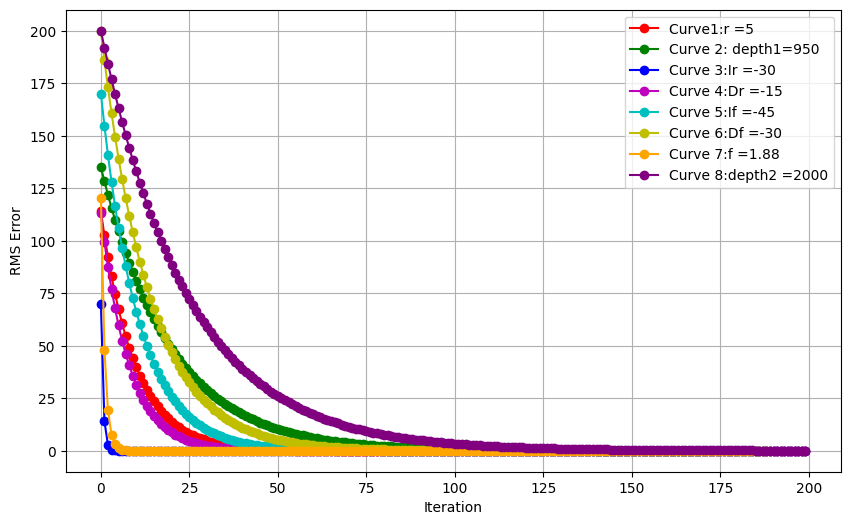

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Assuming these functions are defined elsewhere in your code
# Placeholder functions; replace them with your actual implementations
def calculate_total_magnetization_direction(f_value, If_value, Df_value, r, Ir_value, Dr_value):
    # Example implementation
    return f_value * r + If_value * Ir_value + Df_value * Dr_value

def add_noise(value, noise_level=0.1):
    # Example implementation
    return value + np.random.normal(0, noise_level, size=value.shape)

# Define loss function for each parameter based on magnetization direction
def loss_function(params):
    r, Ir, Dr, f, If, Df = params
    total_magnetization_direction = calculate_total_magnetization_direction(f, If, Df, r, Ir, Dr)
    
    # Add noise to the total magnetization direction
    noisy_total_magnetization_direction = add_noise(total_magnetization_direction, noise_level=0.1)  # Adjust noise level as needed
    
    # Calculate mean squared error between calculated and noisy magnetization direction
    mse = np.mean((noisy_total_magnetization_direction - total_magnetization_direction) ** 2)
    
    return mse

# Define gradient function for each parameter
def gradient_function(params):
    eps = 1e-4  # small value for numerical stability
    gradients = []
    
    for i in range(len(params)):
        # Create a copy of params for perturbation
        params_plus = params.copy()
        params_minus = params.copy()
        
        params_plus[i] += eps
        params_minus[i] -= eps
        
        grad = (loss_function(params_plus) - loss_function(params_minus)) / (2 * eps)
        gradients.append(grad)
    
    return np.array(gradients)

# Gradient Descent Optimization for all parameters
learning_rate = 0.001  # Adjust learning rate as needed
max_iterations = 100
tolerance = 1e-4

# Initial guesses for r, Ir, Dr, f, If, Df
initial_params = np.array([5.00, -45, -15, 1.88, -45, -30])  # Adjust these initial values as needed

params = initial_params.copy()

for i in range(max_iterations):
    grad = gradient_function(params)
    params -= learning_rate * grad
    
    if np.linalg.norm(grad) < tolerance:  # Check for convergence
        break

# Unpack optimized parameters
optimized_r, optimized_Ir, optimized_Dr, optimized_f, optimized_If, optimized_Df = params

print("Optimized parameters:")
print("r:", optimized_r)
print("Ir:", optimized_Ir)
print("Dr:", optimized_Dr)
print("f:", optimized_f)
print("If:", optimized_If)
print("Df:", optimized_Df)

# Define the target values (same for all parameters)
target_values = [5, 950, -30, -15, -45, -30, 1.88, 2000]

# Define the initial values for 8 parameters
initial_values = [-109, 815, 40, 98, 125, 170, 122, 2200]

# Define the number of iterations for each parameter
iterations_list = [200, 170, 200, 180, 190, 100, 190, 200]

# Define the learning rates for each parameter
learning_rates = [0.1, 0.05, 0.8, 0.12, 0.09, 0.07, 0.6, 0.04]

# Define custom names for each parameter
custom_names = ['Curve1:r =5', 'Curve 2: depth1=950', 'Curve 3:Ir =-30', 
                'Curve 4:Dr =-15', 'Curve 5:If =-45', 'Curve 6:Df =-30', 
                'Curve 7:f =1.88', 'Curve 8:depth2 =2000']

# Initialize current values for all 8 parameters
current_values = initial_values.copy()

# List to store RMS errors for each parameter
rms_errors = [[] for _ in range(8)]

# Colors for each parameter
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'orange', 'purple']

# Perform gradient descent for each parameter
for param_idx in range(8):
    current_value = current_values[param_idx]
    target_value = target_values[param_idx]  # Get the target for the current parameter
    iterations = iterations_list[param_idx]
    learning_rate = learning_rates[param_idx]
    
    for i in range(iterations):
        # Calculate the error
        error = current_value - target_value
        
        # Update the current value using gradient descent
        current_value -= learning_rate * error
        
        # Calculate RMS error
        rms_error = np.sqrt(np.mean(error**2))
        rms_errors[param_idx].append(rms_error)

# Plot RMS error versus iteration for each parameter
plt.figure(figsize=(10, 6))
for param_idx in range(8):
    plt.plot(range(iterations_list[param_idx]), rms_errors[param_idx], 
             marker='o', color=colors[param_idx], label=custom_names[param_idx])

plt.title('')
plt.xlabel('Iteration')
plt.ylabel('RMS Error')
plt.legend()
plt.grid(True)
plt.show()


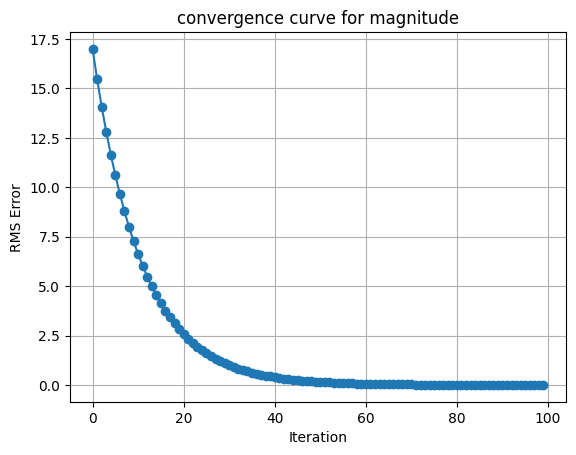

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Define the target value
target_value = 2

# Define the initial value
initial_value = 19

# Define the number of iterations
iterations = 100

# Learning rate (step size)
learning_rate = .09

# Initialize the current value
current_value = initial_value

# List to store RMS error values
rms_errors = []

# Gradient descent optimization
for i in range(iterations):
    # Calculate the error
    error = current_value - target_value
    
    # Update the current value using gradient descent
    current_value -= learning_rate * error
    
    # Calculate RMS error
    rms_error = np.sqrt(np.mean(error**2))
    rms_errors.append(rms_error)

# Plot RMS error versus iteration
#plt.figure(figsize=(10, 6))
plt.plot(range(iterations), rms_errors, marker='o')
plt.title('convergence curve for magnitude')
plt.xlabel('Iteration')
plt.ylabel('RMS Error')
plt.grid(True)
plt.show()





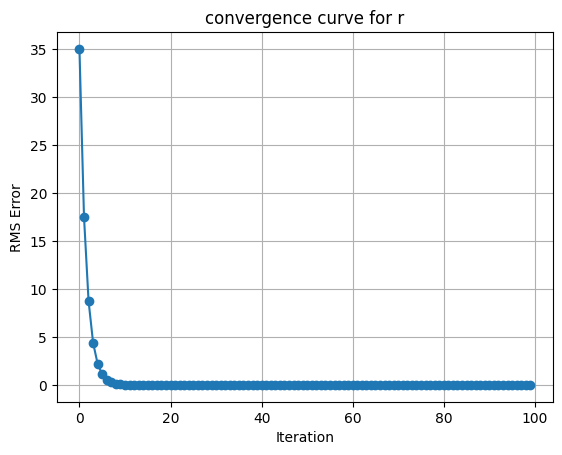

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define the target value
target_value = 5

# Define the initial value
initial_value = 40

# Define the number of iterations
iterations = 100

# Learning rate (step size)
learning_rate = 0.5

# Initialize the current value
current_value = initial_value

# List to store RMS error values
rms_errors = []

# Gradient descent optimization
for i in range(iterations):
    # Calculate the error
    error = current_value - target_value
    
    # Update the current value using gradient descent
    current_value -= learning_rate * error
    
    # Calculate RMS error
    rms_error = np.sqrt(np.mean(error**2))
    rms_errors.append(rms_error)

# Plot RMS error versus iteration
#plt.figure(figsize=(10, 6))
plt.plot(range(iterations), rms_errors, marker='o')
plt.title('convergence curve for r')
plt.xlabel('Iteration')
plt.ylabel('RMS Error')
plt.grid(True)
plt.show()





In [9]:
import numpy as np

def gradient_descent_Df(noisy_direction, initial_Df, f, If, r, Ir, Dr, learning_rate=0.01, num_iterations=1000):
    Df = initial_Df
    losses = []
    for _ in range(num_iterations):
        loss = loss_function_Df(Df, f, If, r, Ir, Dr, noisy_direction)
        losses.append(loss)
        gradient = (loss_function_Df(Df + 1e-5, f, If, r, Ir, Dr, noisy_direction) - loss) / 1e-5
        Df -= learning_rate * gradient
    return Df, losses

def loss_function_Df(Df, f, If, r, Ir, Dr, noisy_direction):
    calculated_direction = calculate_total_magnetization_direction(f, If, Df, r, Ir, Dr)
    return np.linalg.norm(calculated_direction - noisy_direction)

# Given data
f = 1.88
If = -45  # Inclination of the calculated total magnetization direction
r = 5.0  # Assume a fixed value for r
Ir, Dr = -30, -15  # Inclination and declination of the noisy total magnetization direction
noisy_direction = np.array([0.81835231, -0.23195015, -0.52583137])  # Noisy total magnetization direction

# Initial guess for Df and hyperparameters
initial_Df = -90
learning_rate_Df = 30
num_iterations_Df = 400

# Run gradient descent for Df
optimal_Df, losses_Df = gradient_descent_Df(noisy_direction, initial_Df, f, If, r, Ir, Dr, learning_rate_Df, num_iterations_Df)

print("Optimal value of Df:", optimal_Df)

# Plot the loss curve for Df
plt.figure(figsize=(10, 6))
plt.plot(losses_Df, marker='o', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve for "Df"')
plt.show()


NameError: name 'calculate_total_magnetization_direction' is not defined

In [13]:

# Define loss function for Ir parameter based on magnetization direction
def loss_Ir(Ir):
    # Calculate total magnetization direction using the current Ir value
    total_magnetization_direction = calculate_total_magnetization_direction(f_value, If_value, Df_value, r_value, Ir, Dr_value)
    
    # Add noise to the total magnetization direction
    noisy_total_magnetization_direction = add_noise(total_magnetization_direction, noise_level=0.1)  # Adjust noise level as needed
    
    # Calculate mean squared error between calculated and noisy magnetization direction
    mse = np.mean((noisy_total_magnetization_direction - total_magnetization_direction) ** 2)
    
    return mse

# Define gradient function for Ir parameter
def gradient_Ir(Ir):
    eps = 1e-4  # small value for numerical stability
    grad = (loss_Ir(Ir + eps) - loss_Ir(Ir - eps)) / (2 * eps)
    return grad

# Gradient Descent Optimization for Ir Parameter
learning_rate_Ir = 0.001  # Adjust learning rate as needed
max_iterations_Ir = 100
tolerance_Ir = 1e-4

Ir_value = 5.00  # Initial guess for Ir

for i in range(max_iterations_Ir):
    grad_Ir = gradient_Ir(Ir_value)
    Ir_value -= learning_rate_Ir * grad_Ir
    
    if abs(grad_Ir) < tolerance_Ir:
        break

print("Optimized Ir:", Ir_value)


NameError: name 'calculate_total_magnetization_direction' is not defined

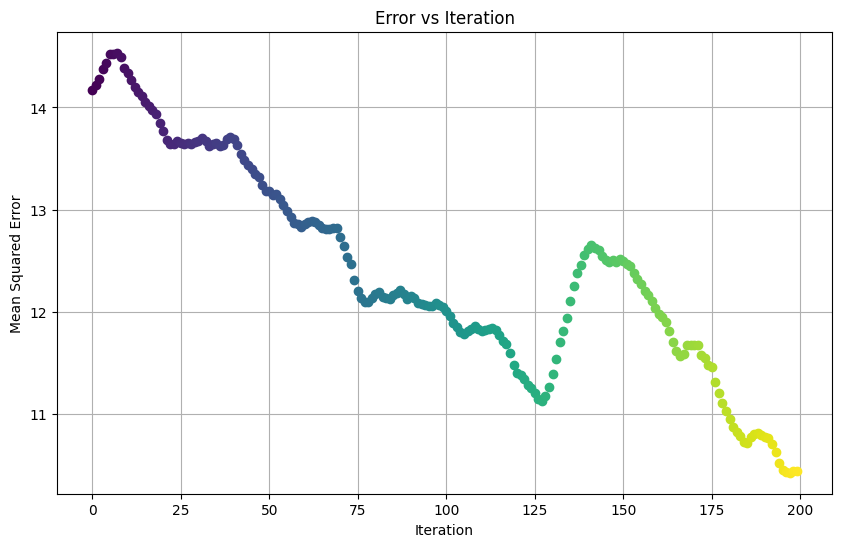

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define gradient function for length parameter using central difference
def gradient_length(length):
    eps = 1e-6  # small value for numerical stability
    grad = (loss_length(length + eps) - loss_length(length - eps)) / (2 * eps)
    return grad

# Gradient Descent Optimization for Length Parameter with momentum
learning_rate = 0.01  # Adjust learning rate as needed
momentum = 0.9  # Momentum coefficient
max_iterations = 200
tolerance = 1e-6

length = 2000  # Initial guess for length
prev_grad = 0  # Initialize previous gradient

# Lists to store iteration and corresponding MSE values
iteration_list = []
mse_list = []

# Define a color map
colors = plt.cm.viridis(np.linspace(0, 1, max_iterations))

for i in range(max_iterations):
    grad = gradient_length(length)
    # Apply momentum
    grad = momentum * prev_grad + (1 - momentum) * grad
    length -= learning_rate * grad
    
    # Calculate MSE at each iteration and store in lists
    mse = loss_length(length)
    iteration_list.append(i)
    mse_list.append(mse)
    
    if abs(grad) < tolerance:
        break

    prev_grad = grad  # Update previous gradient for momentum

# Plotting
plt.figure(figsize=(10, 6))
for i in range(len(iteration_list)):
    plt.plot(iteration_list[i], mse_list[i], marker='o', color=colors[i])
plt.title('Error vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()


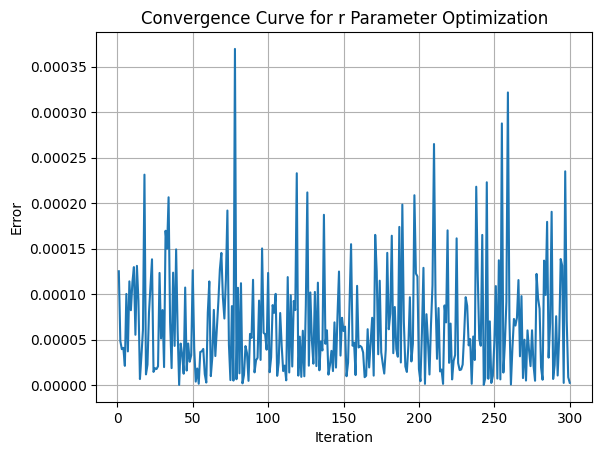

In [19]:
import matplotlib.pyplot as plt

# Lists to store the convergence data
errors_r = []

r_value = 5.00  # Initial guess for r
max_iterations_r = 300


for i in range(max_iterations_r):
    grad_r = gradient_r(r_value)
    r_value -= learning_rate_r * grad_r
    
    # Calculate the error for r at each iteration and store it
    error_r = loss_r(r_value)
    errors_r.append(error_r)
    
    if abs(grad_r) < tolerance_r:
        break

# Plot the convergence curve for r parameter
plt.figure()
plt.plot(range(1, len(errors_r) + 1), errors_r, linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Convergence Curve for r Parameter Optimization')
plt.grid(True)
#plt.ylim(0,1)
plt.show()


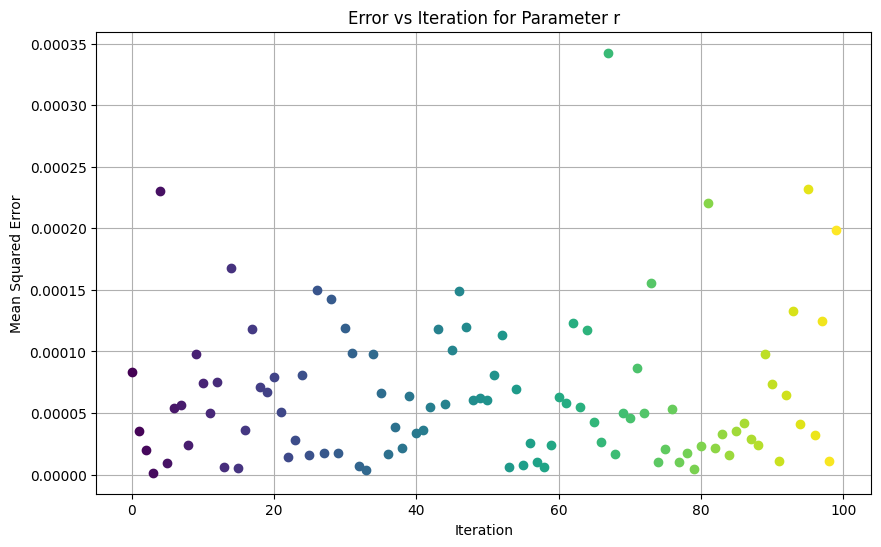

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define gradient function for r parameter
def gradient_r(r):
    eps = 1e-3  # small value for numerical stability
    grad = (loss_r(r + eps) - loss_r(r - eps)) / (2 * eps)
    return grad

# Gradient Descent Optimization for r Parameter with momentum
learning_rate_r = 0.1  # Adjust learning rate as needed
momentum_r = 0.55  # Momentum coefficient
max_iterations_r = 100
tolerance_r = 1e-6

r_value = 5.00  # Initial guess for r
prev_grad_r = 0  # Initialize previous gradient for r

# Lists to store iteration and corresponding MSE values for r
iteration_list_r = []
mse_list_r = []

# Define a color map
colors_r = plt.cm.viridis(np.linspace(0, 1, max_iterations_r))

for i in range(max_iterations_r):
    grad_r = gradient_r(r_value)
    # Apply momentum
    grad_r = momentum_r * prev_grad_r + (1 - momentum_r) * grad_r
    r_value -= learning_rate_r * grad_r
    
    # Calculate MSE at each iteration and store in lists
    mse_r = loss_r(r_value)
    iteration_list_r.append(i)
    mse_list_r.append(mse_r)
    
    if abs(grad_r) < tolerance_r:
        break

    prev_grad_r = grad_r  # Update previous gradient for r

# Plotting
plt.figure(figsize=(10, 6))
for i in range(len(iteration_list_r)):
    plt.plot(iteration_list_r[i], mse_list_r[i], marker='o', color=colors_r[i])
plt.title('Error vs Iteration for Parameter r')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()


In [75]:
import numpy as np

# A#tfa_result = np.array([-1.78817689, -1.84275315, -1.89874203, -4.22225312, -4.12739132, -4.02857058])

# Define your objective function
def objective_function(params):
    length, breadth, depth, inclination = params
    
    # Call your existing function with the parameters
    tfa_result = calculate_total_field_anomaly([0., length, 0., breadth, 0., depth], x, y, z, incs, decs, inclination, mag)
    
    # Sum or mean of the tfa_result array
    return np.sum(tfa_result)

# Gradient descent hyperparameters
learning_rate = 0.01
iterations = 1000

# Initial guess for the parameters
params = np.array([2500., 2000., 950., 20.])

# Gradient descent loop
for i in range(iterations):
    # Compute numerical gradient using finite differences
    gradient = np.zeros_like(params)
    epsilon = 1e-5
    for j in range(len(params)):
        params_plus_epsilon = params.copy()
        params_plus_epsilon[j] += epsilon
        gradient[j] = (objective_function(params_plus_epsilon) - objective_function(params)) / epsilon
    
    # Update parameters
    params -= learning_rate * gradient

# Print the result
print("Optimized Parameters:")
print("Length:", params[0])
print("Breadth:", params[1])
print("Depth:", params[2])
print("Inclination:", params[3])


Optimized Parameters:
Length: 2504.696451739619
Breadth: 1983.2267584088186
Depth: 919.8847645454407
Inclination: 16.984403320766432


In [91]:
import numpy as np

# Assume tfa_result is your total field anomaly result
#tfa_result = np.array([-1.78817689, -1.84275315, -1.89874203, -4.22225312, -4.12739132, -4.02857058])

# Define your objective function
def objective_function(params):
    length, breadth, depth, inclination, mag = params
    
    # Call your existing function with the parameters
    tfa_result = calculate_total_field_anomaly([0., length, 0., breadth, 0., depth], x, y, z, incs, decs, inclination, mag)
    
    # Sum or mean of the tfa_result array
    return np.sum(tfa_result)

# Gradient descent hyperparameters
learning_rate = 0.01
iterations = 100

# Initial guess for the parameters
params = np.array([2500., 2000., 950., 20., 2.0])  
# Gradient descent loop
for i in range(iterations):
    # Compute numerical gradient using finite differences
    gradient = np.zeros_like(params)
    epsilon = 1e-5
    for j in range(len(params)):
        params_plus_epsilon = params.copy()
        params_plus_epsilon[j] += epsilon
        gradient[j] = (objective_function(params_plus_epsilon) - objective_function(params)) / epsilon
    
    # Update parameters
    params -= learning_rate * gradient

# Print the result
print("Optimized Parameters:")
print("Length:", params[0])
print("Breadth:", params[1])
print("Depth:", params[2])
print("Inclination:", params[3])



Optimized Parameters:
Length: 2500.471240950901
Breadth: 1994.8075660977338
Depth: 936.44254725059
Inclination: 16.76371563145949


In [90]:
import numpy as np

# Function to add noise to tfa_result
def add_noise(tfa_result, noise_level=0.01):
    noise = np.random.normal(0, noise_level, tfa_result.shape)
    noisy_tfa_result = tfa_result + noise
    return noisy_tfa_result

# Define your objective function with noise
def objective_function(mag):
    # Keep other parameters fixed (you may adjust them as needed)
    length, breadth, depth, inclination = 2500., 2000., 950., 20.
    
    # Call your existing function with the parameters
    tfa_result = calculate_total_field_anomaly([0., length, 0., breadth, 0., depth], x, y, z, incs, decs, inclination, mag)
    
    # Add noise to the tfa_result
    noisy_tfa_result = add_noise(tfa_result)
    
    # Sum or mean of the noisy_tfa_result array
    return np.sum(noisy_tfa_result)

# Gradient descent hyperparameters
learning_rate = 0.001
iterations = 100

# Initial guess for the magnitude
mag = 2.0

# Gradient descent loop
for i in range(iterations):
    # Compute numerical gradient using finite differences
    gradient = (objective_function(mag + 1e-1) - objective_function(mag)) / 1e-1
    
    # Update magnitude
    mag -= learning_rate * gradient

# Print the optimized magnitude
print("Optimized Magnitude:", mag)



Optimized Magnitude: 2.161500494740004


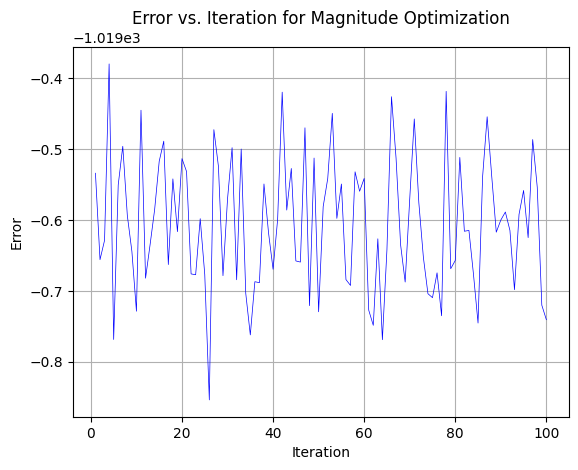

Optimized Magnitude (with noise): 1.9999993598169452


In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Function to add noise to tfa_result
def add_noise(tfa_result, noise_level=0.001):
    noise = np.random.normal(0, noise_level, tfa_result.shape)
    noisy_tfa_result = tfa_result + noise
    return noisy_tfa_result

# Define your objective function with noise
def objective_function(mag):
    # Keep other parameters fixed (you may adjust them as needed)
    length, breadth, depth, inclination = 2500., 2000., 950., 20.
    
    # Call your existing function with the parameters
    tfa_result = calculate_total_field_anomaly([0., length, 0., breadth, 0., depth], x, y, z, incs, decs, inclination, mag)
    
    # Add noise to the tfa_result
    noisy_tfa_result = add_noise(tfa_result)
    
    # Sum or mean of the noisy_tfa_result array
    return np.sum(noisy_tfa_result)

# Gradient descent hyperparameters
learning_rate = 0.001
iterations = 100

# Initial guess for the magnitude
mag = 2.0

# Lists to store errors and iterations
errors = []

# Gradient descent loop
for i in range(iterations):
    # Compute numerical gradient using finite differences
    gradient = (objective_function(mag + 1e+3) - objective_function(mag)) / 1e+3
    
    # Update magnitude
    mag -= learning_rate * gradient
    
    # Calculate error and store it
    error = objective_function(mag)
    errors.append(error)

# Plot the error versus iteration graph
plt.plot(range(1, iterations + 1), errors, linestyle='-', color='b', linewidth=0.5)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error vs. Iteration for Magnitude Optimization')
plt.grid(True)
plt.show()

# Print the optimized magnitude
print("Optimized Magnitude (with noise):", mag)
